In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from scipy.integrate import odeint
from matplotlib.gridspec import GridSpec 
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import block_diag
%config InlineBackend.figure_format = 'retina'
import pandas as pd

# SINDY 

In [3]:
## Lorenz 
def Lorenz(x0, sigma, rho, beta, t):
    def dynamical_system(y,t):
        dy = np.zeros_like(y)
        dy[0] = sigma*(y[1]-y[0])
        dy[1] = y[0]*(rho-y[2]) - y[1]
        dy[2] = y[0]*y[1] - beta*y[2]
        return dy
    x = odeint(dynamical_system, x0, t, rtol=1e-12, atol=1e-12)
    dt = t[1] - t[0]
    xdot = np.gradient(x, dt, axis=0)
    return x, xdot

In [4]:
#chaotic parameters
sigma, rho, beta = 10., 28., 8./3.

In [5]:
t = np.arange(0, 100, 0.01)
x0 = np.array([-8., 7., 27.])
x, dx = Lorenz(x0, sigma, rho, beta, t)

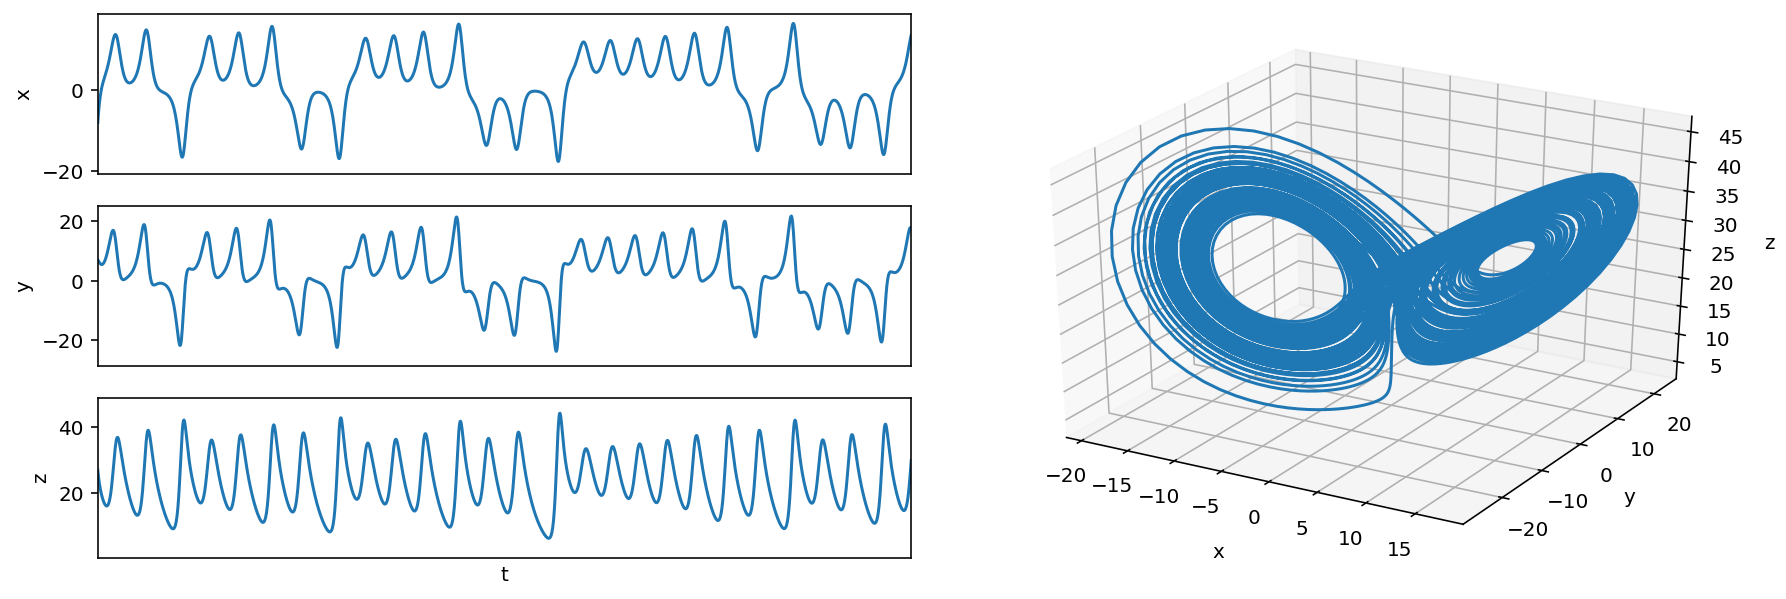

In [6]:
w = 10
fig = plt.figure(figsize=(1.5*w, w/2))
gs = GridSpec(3, 6)

ax0 = fig.add_subplot(gs[0, :3])
ax0.plot(t, x[:, 0])
ax0.set_ylabel('x')
ax0.set_xticks([])
ax0.set_xlim(0, 20)

ax1 = fig.add_subplot(gs[1, :3])
ax1.plot(t, x[:, 1])
ax1.set_ylabel('y')
ax1.set_xticks([])
ax1.set_xlim(0, 20)

ax2 = fig.add_subplot(gs[2, :3])
ax2.plot(t, x[:, 2])
ax2.set_ylabel('z')
ax2.set_xlabel('t')
ax2.set_xticks([])
ax2.set_xlim(0, 20)

ax3 = fig.add_subplot(gs[:, 3:], projection='3d')
ax3.plot(x[:, 0], x[:, 1], x[:, 2])
ax3.set_xlabel('x', labelpad=10)
ax3.set_ylabel('y')
ax3.set_zlabel('z')
plt.savefig('lorenz_attractor.pdf', transparent=True)

In [7]:
# Non-linear function library
library = PolynomialFeatures(degree=5, include_bias=True)
# include_bias parameter is for the feature in which all polynomial powers are zero - column of ones
Theta = library.fit_transform(x)
n_lib = library.n_output_features_

In [8]:
feature_library = pd.DataFrame(data=Theta, columns=library.get_feature_names())

In [9]:
feature_library.head()

,1,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2,...,x0 x1^3 x2,x0 x1^2 x2^2,x0 x1 x2^3,x0 x2^4,x1^5,x1^4 x2,x1^3 x2^2,x1^2 x2^3,x1 x2^4,x2^5
0,1.0,-8.000000,7.000000,27.000000,64.000000,-56.000000,-216.000000,49.000000,189.000000,729.000000,...,-74088.000000,-285768.000000,-1.102248e+06,-4.251528e+06,16807.000000,64827.000000,250047.000000,964467.000000,3.720087e+06,1.434891e+07
1,1.0,-6.581023,6.814745,25.793149,43.309859,-44.847992,-169.745297,46.440753,175.773740,665.286537,...,-53721.313833,-203329.956531,-7.695841e+05,-2.912801e+06,14697.657597,55629.206865,210551.146401,796915.644661,3.016248e+06,1.141621e+07
2,1.0,-5.317130,6.585408,24.721766,28.271874,-35.015472,-131.448851,43.367600,162.802921,611.165736,...,-37540.916760,-140929.425090,-5.290522e+05,-1.986073e+06,12385.497752,46495.430274,174544.865268,655245.253391,2.459805e+06,9.234162e+06
3,1.0,-4.196173,6.343044,23.768497,17.607867,-26.616507,-99.736723,40.234202,150.764612,564.941451,...,-25453.539109,-95378.876567,-3.574014e+05,-1.339246e+06,10268.061682,38476.228534,144177.178523,540257.182127,2.024438e+06,7.585926e+06
4,1.0,-3.204675,6.109339,22.916339,10.269940,-19.578444,-73.439413,37.324021,140.003679,525.158587,...,-16746.028640,-62814.926165,-2.356209e+05,-8.838222e+05,8510.813177,31924.351309,119749.333613,449183.845962,1.684904e+06,6.320132e+06


### The ordinary least squares solution

In [10]:
%%time
x_lstsq = np.linalg.lstsq(Theta, dx, rcond=None)[0]
print('Total number of possible coefficients:', x_lstsq.size)
print('Number of non-zero coefficients:', np.count_nonzero(x_lstsq))

Total number of possible coefficients: 168
Number of non-zero coefficients: 168
CPU times: user 102 ms, sys: 17.1 ms, total: 120 ms
Wall time: 46 ms


#### All of the coefficients are non-zero, this indicates overfitting.

In [11]:
x_lssq = pd.DataFrame(data=x_lstsq, columns=('x0','x1','x2'), index=library.get_feature_names())

In [12]:
x_lssq.head(n=8)

,x0,x1,x2
1,-0.550057,-0.297192,0.513600
x0,-7.216103,29.766407,-2.735770
x1,8.651794,-1.827582,1.332730
x2,0.249007,0.135267,-2.900722
x0^2,0.054495,0.035122,-0.076402
x0 x1,-0.066318,-0.042275,1.094324
x0 x2,-0.555552,-1.316271,0.525258
x1^2,0.017836,0.011334,-0.022179


### Lasso solution - $l_{1}$ penalized least squares

In [13]:
%%time
lasso_fit = Lasso(alpha=0.1, max_iter=10000).fit(Theta, dx)
print('Total number of possible coefficients:', lasso_fit.coef_.size)
print('Number of non-zero coefficients:', np.count_nonzero(lasso_fit.coef_))

/Users/irem/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7918.648073246296, tolerance: 1901.970539324249
  model = cd_fast.enet_coordinate_descent(
/Users/irem/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23035.347920725566, tolerance: 4408.8567724586965
  model = cd_fast.enet_coordinate_descent(


Total number of possible coefficients: 168
Number of non-zero coefficients: 157
CPU times: user 21.8 s, sys: 1.92 s, total: 23.7 s
Wall time: 7.37 s


In [14]:
x_lasso = pd.DataFrame(data=lasso_fit.coef_.T, columns=('x0','x1','x2'), index=library.get_feature_names())

In [15]:
x_lasso.head()

,x0,x1,x2
1,0.000000,0.000000,0.000000
x0,-0.000000,18.632774,0.000000
x1,4.384479,2.848296,-0.000000
x2,0.000000,0.000000,-1.504506
x0^2,-0.014314,0.000000,0.436293


### Sequential - thresholded least squares solution

In [16]:
%time
threshold = 0.025
x_new = np.linalg.lstsq(Theta, dx, rcond=None)[0] #initial guess 
for k in range(10):
    small_indices = np.abs(x_new) < threshold
    x_new[small_indices] = 0
    for i in range(3):
        big_indices = ~small_indices[:,i]
        x_new[big_indices,i] = np.linalg.lstsq(Theta[:,big_indices], dx[:,i], rcond=None)[0]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


#### As stated in the paper, sequential-thresholded solution is 10^6 times faster than Lasso solution.

In [17]:
x_ht = pd.DataFrame(data=x_new, columns=('x0','x1','x2'), index=library.get_feature_names())
print('Total number of possible coefficients:', x_new.size)
print('Number of non-zero coefficients:', np.count_nonzero(x_new))

Total number of possible coefficients: 168
Number of non-zero coefficients: 7


In [18]:
x_ht.head(n=7)

,x0,x1,x2
1,0.000000,0.000000,0.000000
x0,-9.977234,27.801360,0.000000
x1,9.977318,-0.961549,0.000000
x2,0.000000,0.000000,-2.658846
x0^2,0.000000,0.000000,0.000000
x0 x1,0.000000,0.000000,0.997070
x0 x2,0.000000,-0.994441,0.000000


### Ridge Solution

In [19]:
%%time
ridge_fit = Ridge(alpha=0.001).fit(Theta, dx)
print('Total number of possible coefficients:', ridge_fit.coef_.size)
print('Number of non-zero coefficients:', np.count_nonzero(ridge_fit.coef_))

Total number of possible coefficients: 168
Number of non-zero coefficients: 165
CPU times: user 53.4 ms, sys: 9.18 ms, total: 62.6 ms
Wall time: 17.3 ms


/Users/irem/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.63793e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [20]:
x_ridge = pd.DataFrame(data=ridge_fit.coef_.T, columns=('x0','x1','x2'), index=library.get_feature_names())

In [21]:
x_ridge.head()

,x0,x1,x2
1,0.000000,0.000000,0.000000
x0,-6.750893,28.478086,-2.588275
x1,8.435102,-1.228016,1.263915
x2,0.259810,0.106164,-2.896213
x0^2,0.062567,0.012280,-0.072913


### Comparison between different identifications

In [22]:
def sindy_model(x,t,library,coeffs):
    dxdt = np.zeros_like(x)
    library = PolynomialFeatures(degree=5, include_bias=True)
    Theta = library.fit_transform(x.reshape(1,-1))
    dxdt = np.dot(Theta, coeffs)
    return dxdt.flatten()

In [23]:
x_least = odeint(sindy_model, x0, t, args=(library, x_lstsq))
x_lasso = odeint(sindy_model, x0, t, args=(library, lasso_fit.coef_.T))
x_ridge = odeint(sindy_model, x0, t, args=(library, ridge_fit.coef_.T))
x_hst = odeint(sindy_model, x0, t, args=(library, x_new))

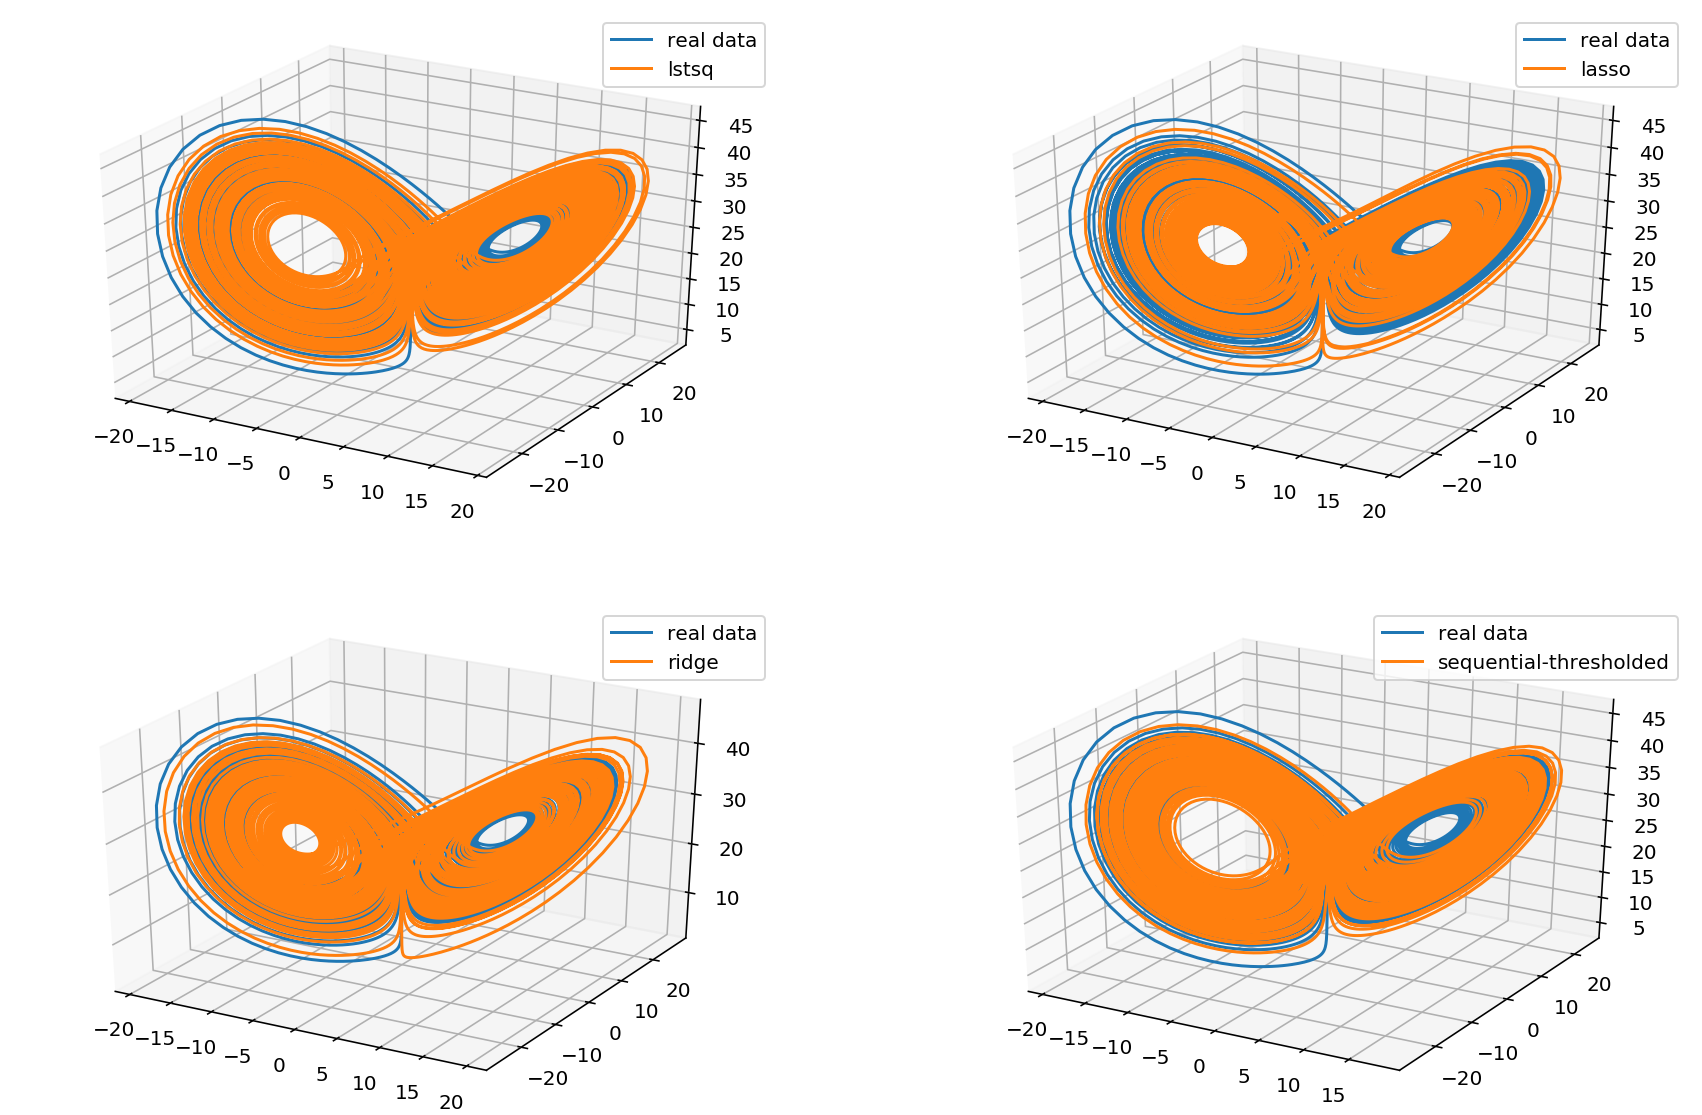

In [24]:
fig = plt.figure(figsize=(1.5*w,w))
gs = GridSpec(ncols=2, nrows=2, figure=fig)

ax1 = fig.add_subplot(gs[0,0], projection='3d')
ax1.plot(x[:,0],x[:,1],x[:,2], label='real data') #gt
ax1.plot(x_least[:,0], x_least[:,1], x_least[:,2], label='lstsq') #leastsq
plt.legend()

ax2 = fig.add_subplot(gs[0,1], projection='3d')
ax2.plot(x[:,0],x[:,1],x[:,2], label='real data') #gt
ax2.plot(x_lasso[:,0], x_lasso[:, 1], x_lasso[:,2], label='lasso') #lasso
plt.legend()

ax3 = fig.add_subplot(gs[1,0], projection='3d')
ax3.plot(x[:,0],x[:,1],x[:,2], label='real data') #gt
ax3.plot(x_ridge[:,0], x_ridge[:, 1], x_ridge[:,2], label='ridge') #ridge
plt.legend()

ax4 = fig.add_subplot(gs[1,1], projection='3d')
ax4.plot(x[:,0],x[:,1],x[:,2], label='real data') #gt
ax4.plot(x_hst[:,0], x_hst[:,1], x_hst[:,2], label='sequential-thresholded') #sequential-tresholded
plt.legend()

### Error of Ordinary Least Squares

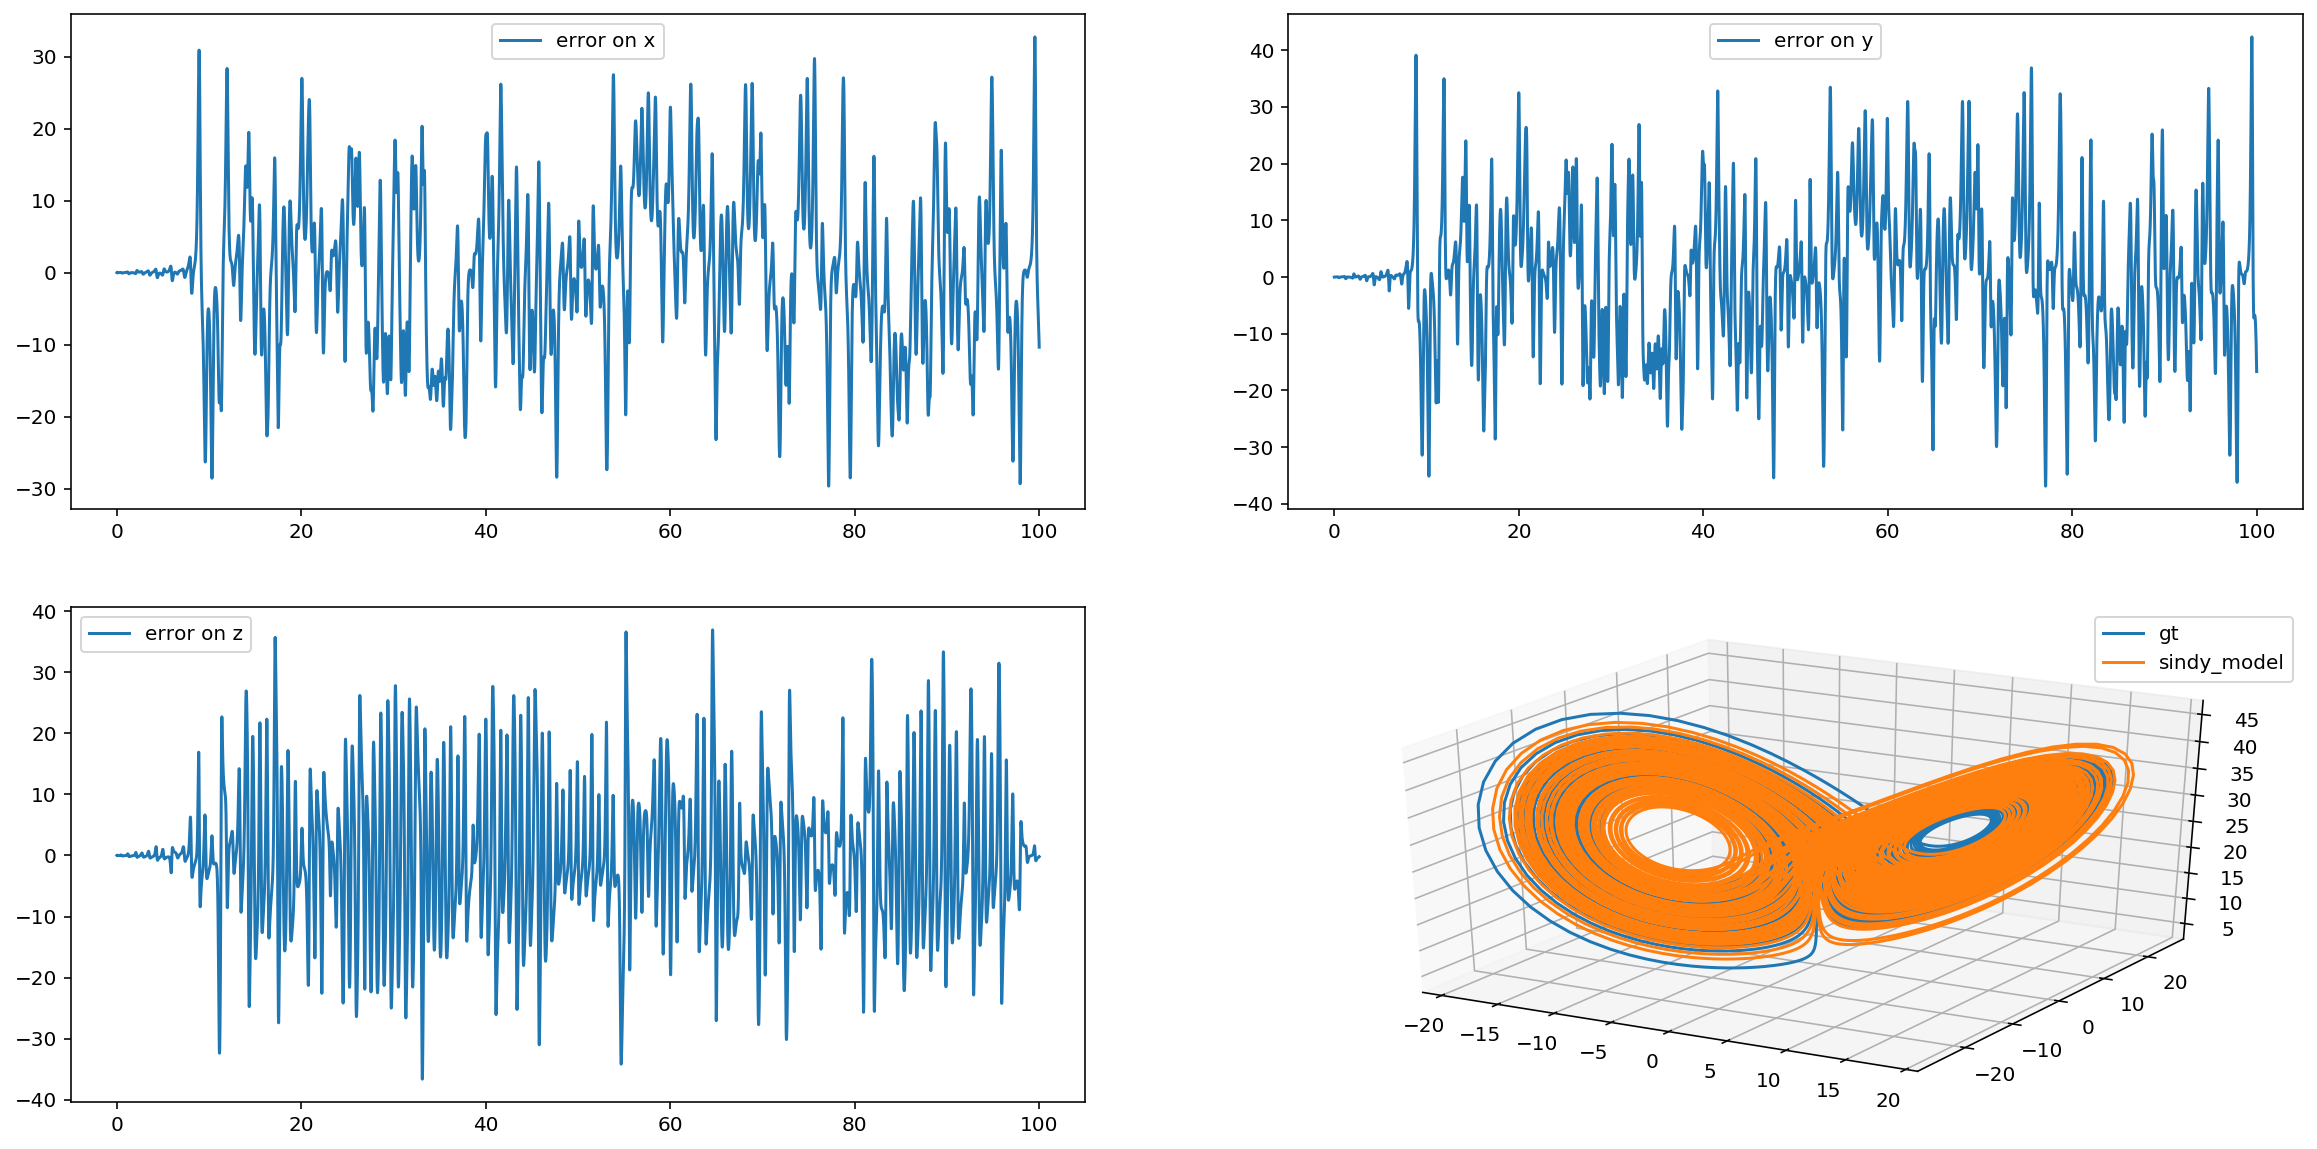

In [25]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(t, x[:,0]-x_least[:,0], label='error on x')
plt.legend()
plt.subplot(222)
plt.plot(t, x[:,1]-x_least[:,1], label='error on y')
plt.legend()
plt.subplot(223)
plt.plot(t, x[:,2]-x_least[:,2], label='error on z')
plt.legend()
plt.subplot(224, projection='3d')
plt.plot(x[:,0], x[:,1], x[:,2], label='gt')
plt.plot(x_least[:,0], x_least[:,1], x_least[:,2], label='sindy_model')
plt.legend()

### Error of Ridge Regression

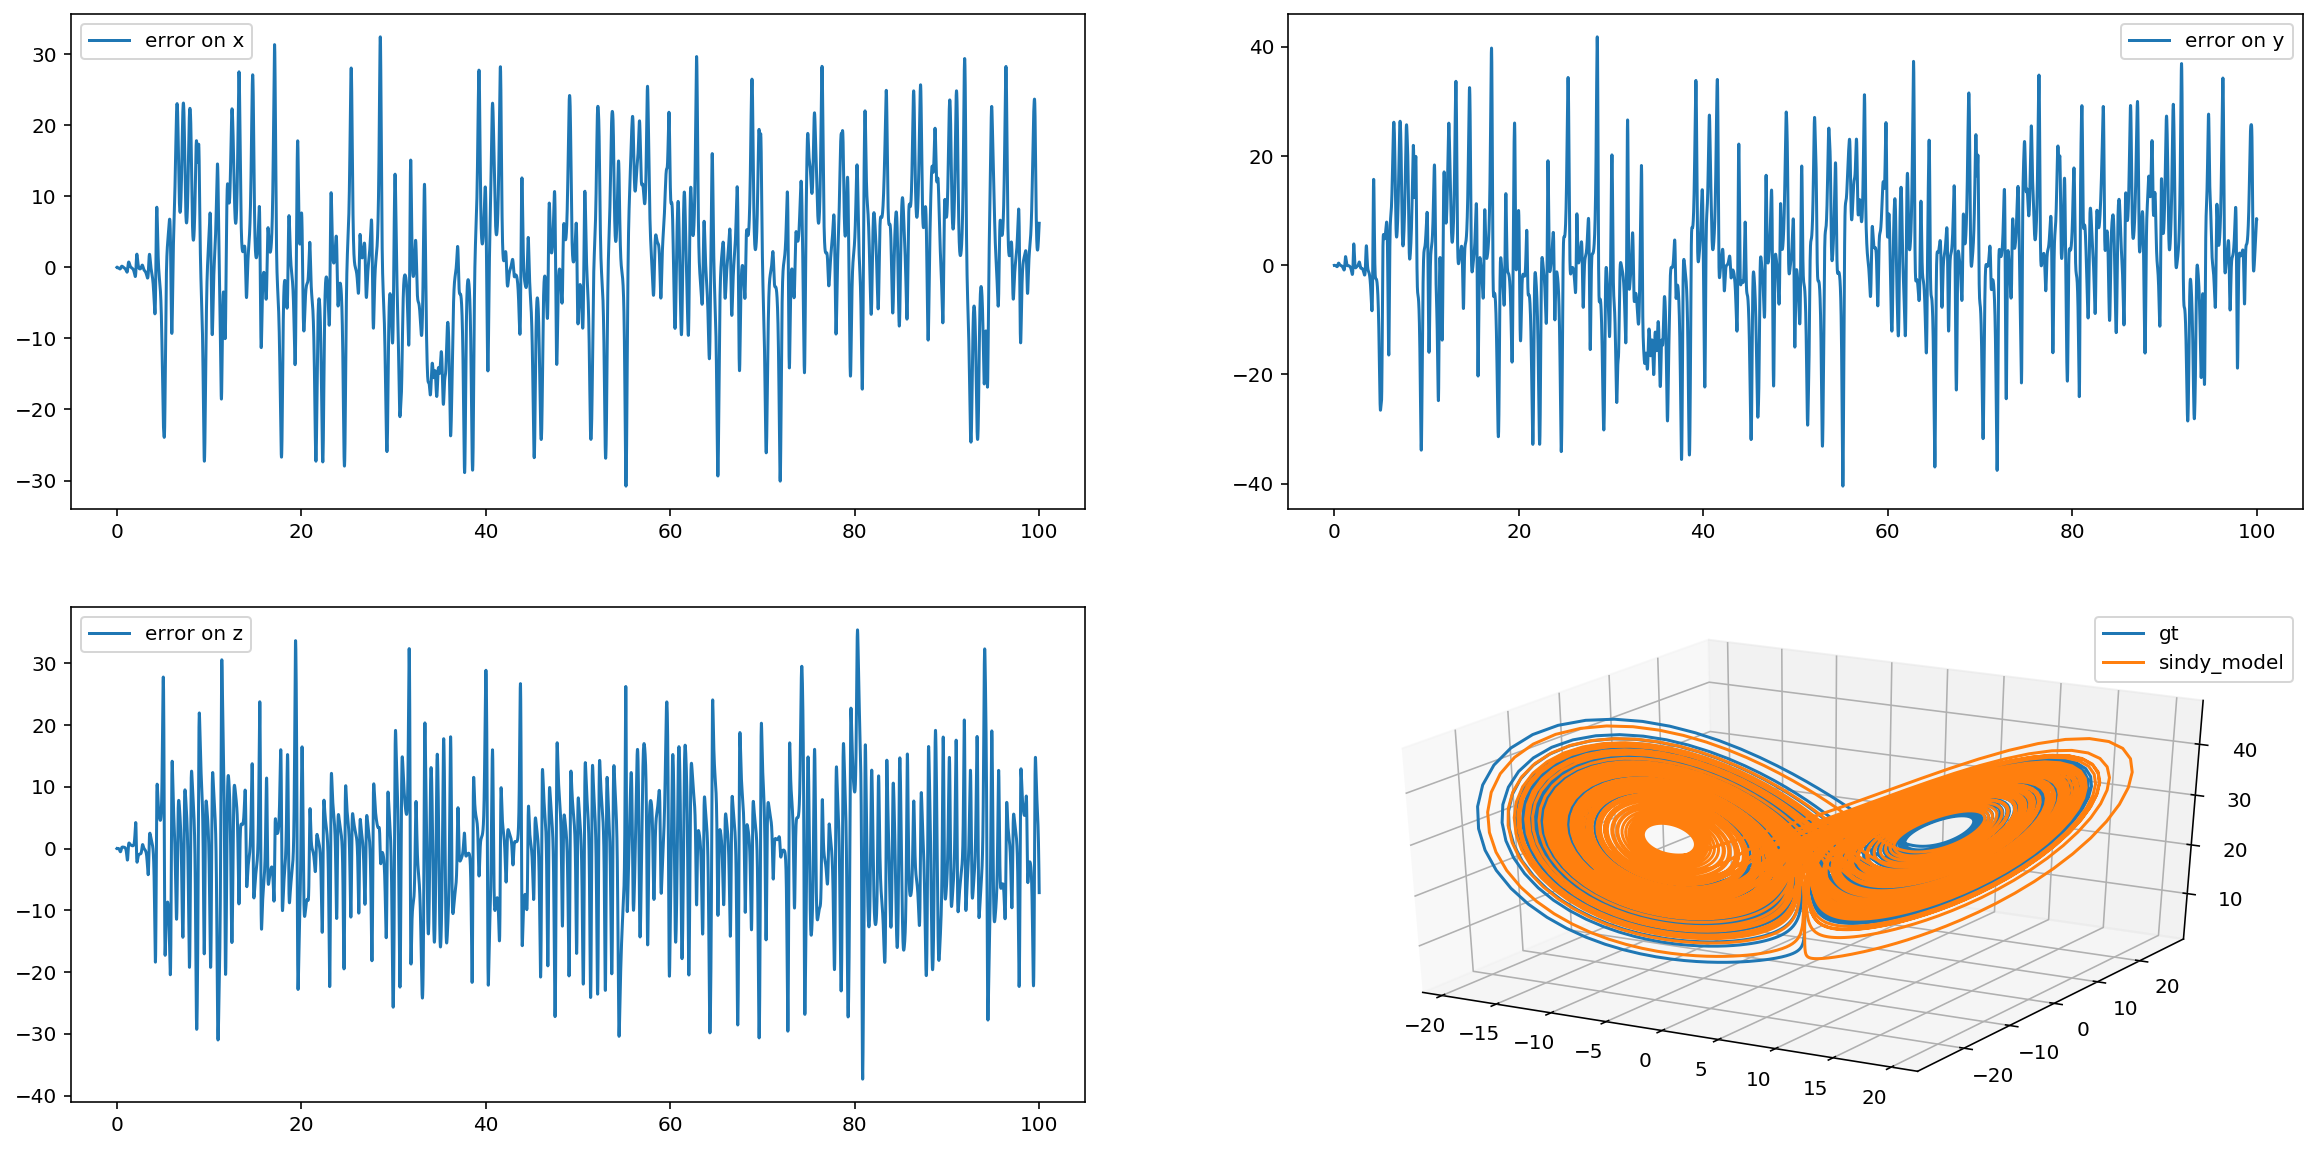

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(t, x[:,0]-x_ridge[:,0], label='error on x')
plt.legend()
plt.subplot(222)
plt.plot(t, x[:,1]-x_ridge[:,1], label='error on y')
plt.legend()
plt.subplot(223)
plt.plot(t, x[:,2]-x_ridge[:,2], label='error on z')
plt.legend()
plt.subplot(224, projection='3d')
plt.plot(x[:,0], x[:,1], x[:,2], label='gt')
plt.plot(x_ridge[:,0], x_ridge[:,1], x_ridge[:,2], label='sindy_model')
plt.legend()

### Error of Lasso Regression

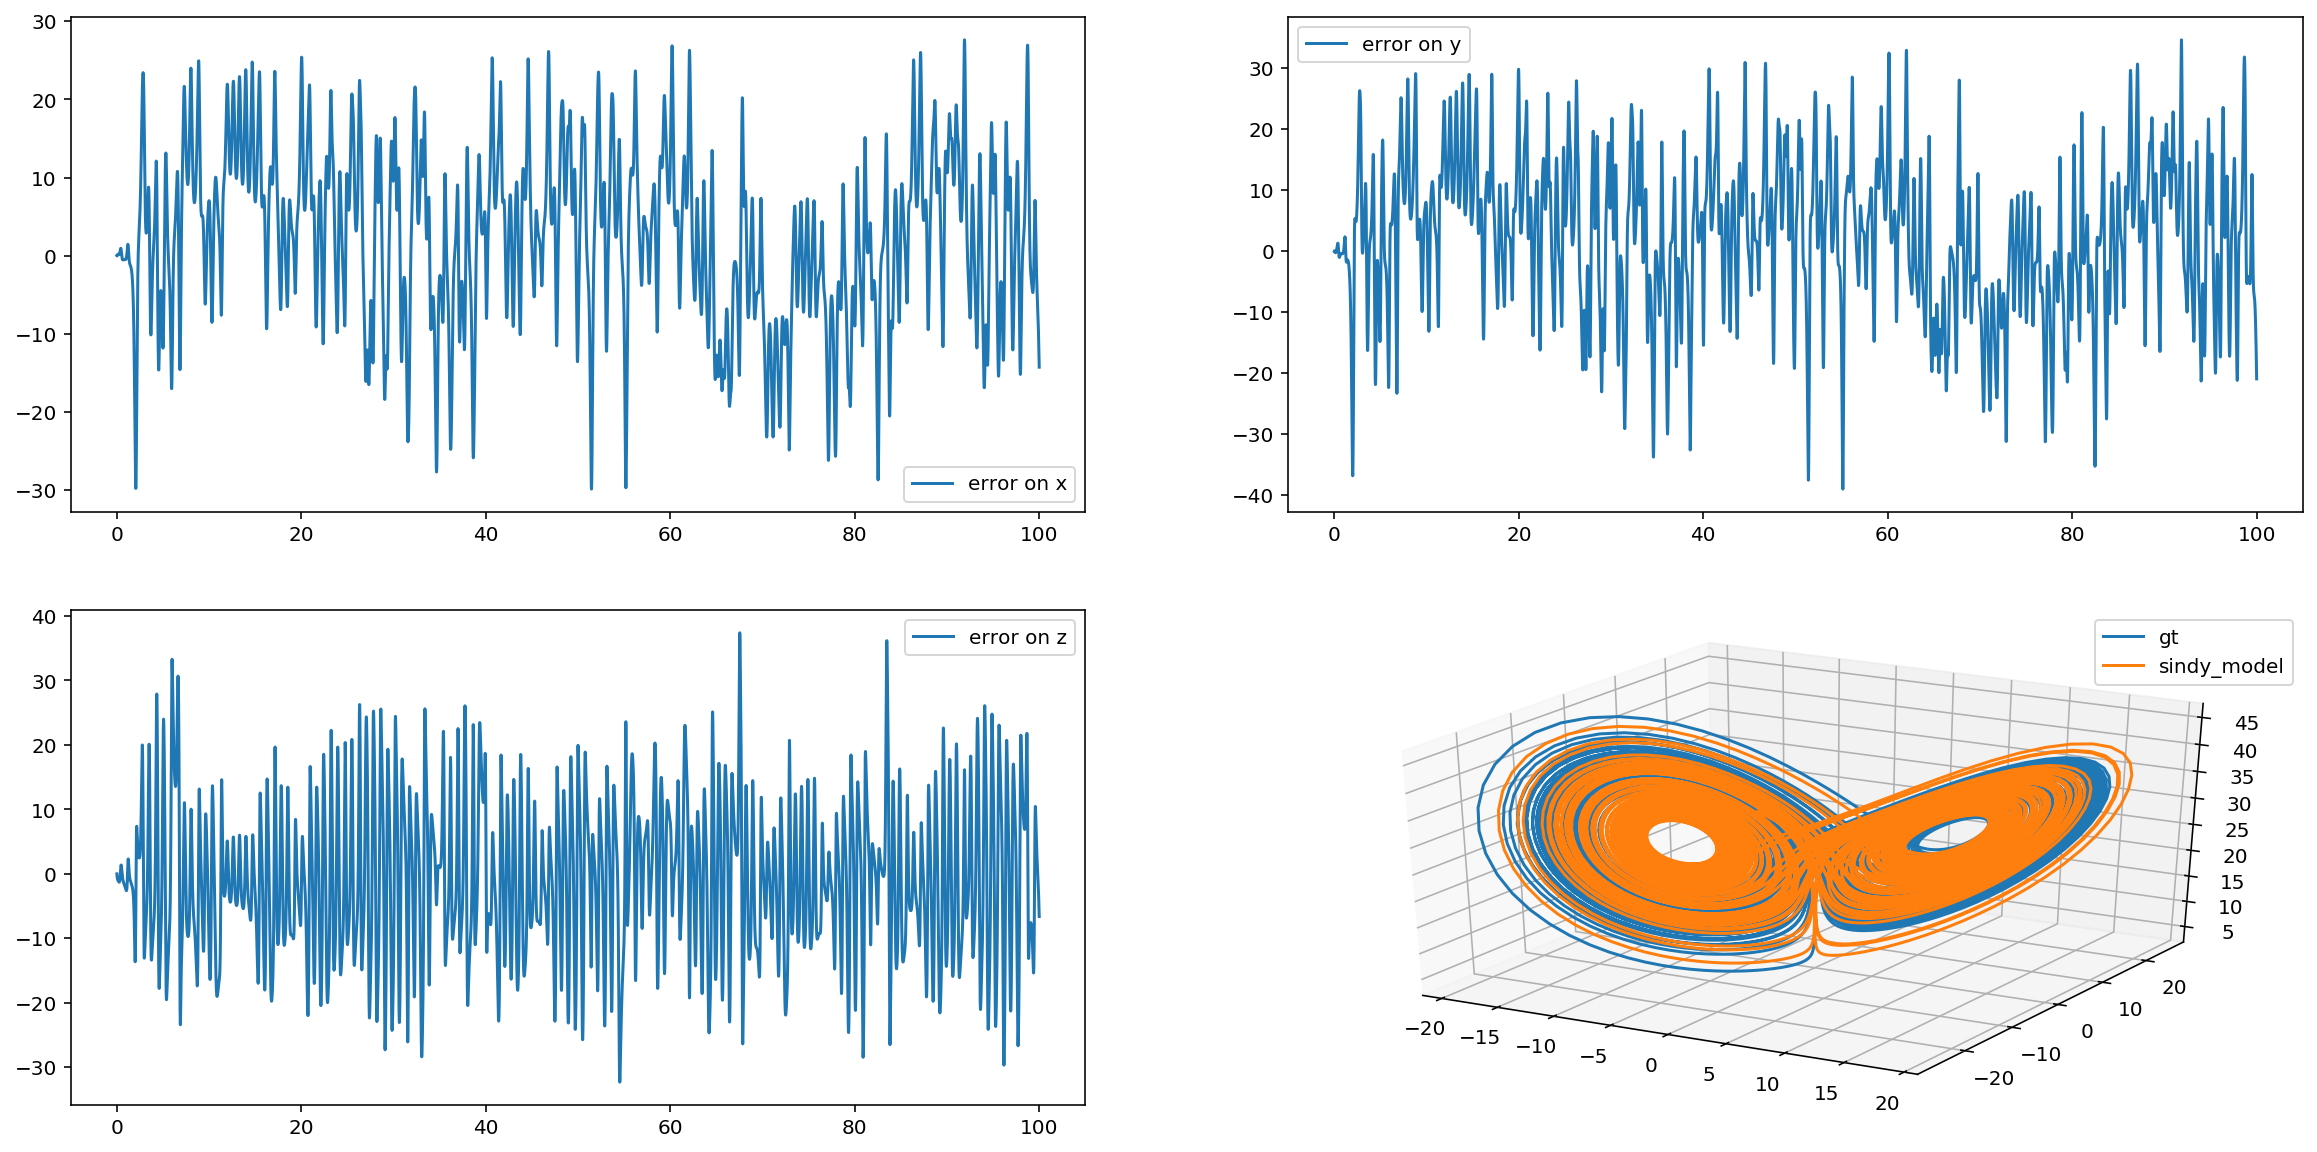

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(t, x[:,0]-x_lasso[:,0], label='error on x')
plt.legend()
plt.subplot(222)
plt.plot(t, x[:,1]-x_lasso[:,1], label='error on y')
plt.legend()
plt.subplot(223)
plt.plot(t, x[:,2]-x_lasso[:,2], label='error on z')
plt.legend()
plt.subplot(224, projection='3d')
plt.plot(x[:,0], x[:,1], x[:,2], label='gt')
plt.plot(x_lasso[:,0], x_lasso[:,1], x_lasso[:,2], label='sindy_model')
plt.legend()

### Error of Sequential - Thresholded Least Squares

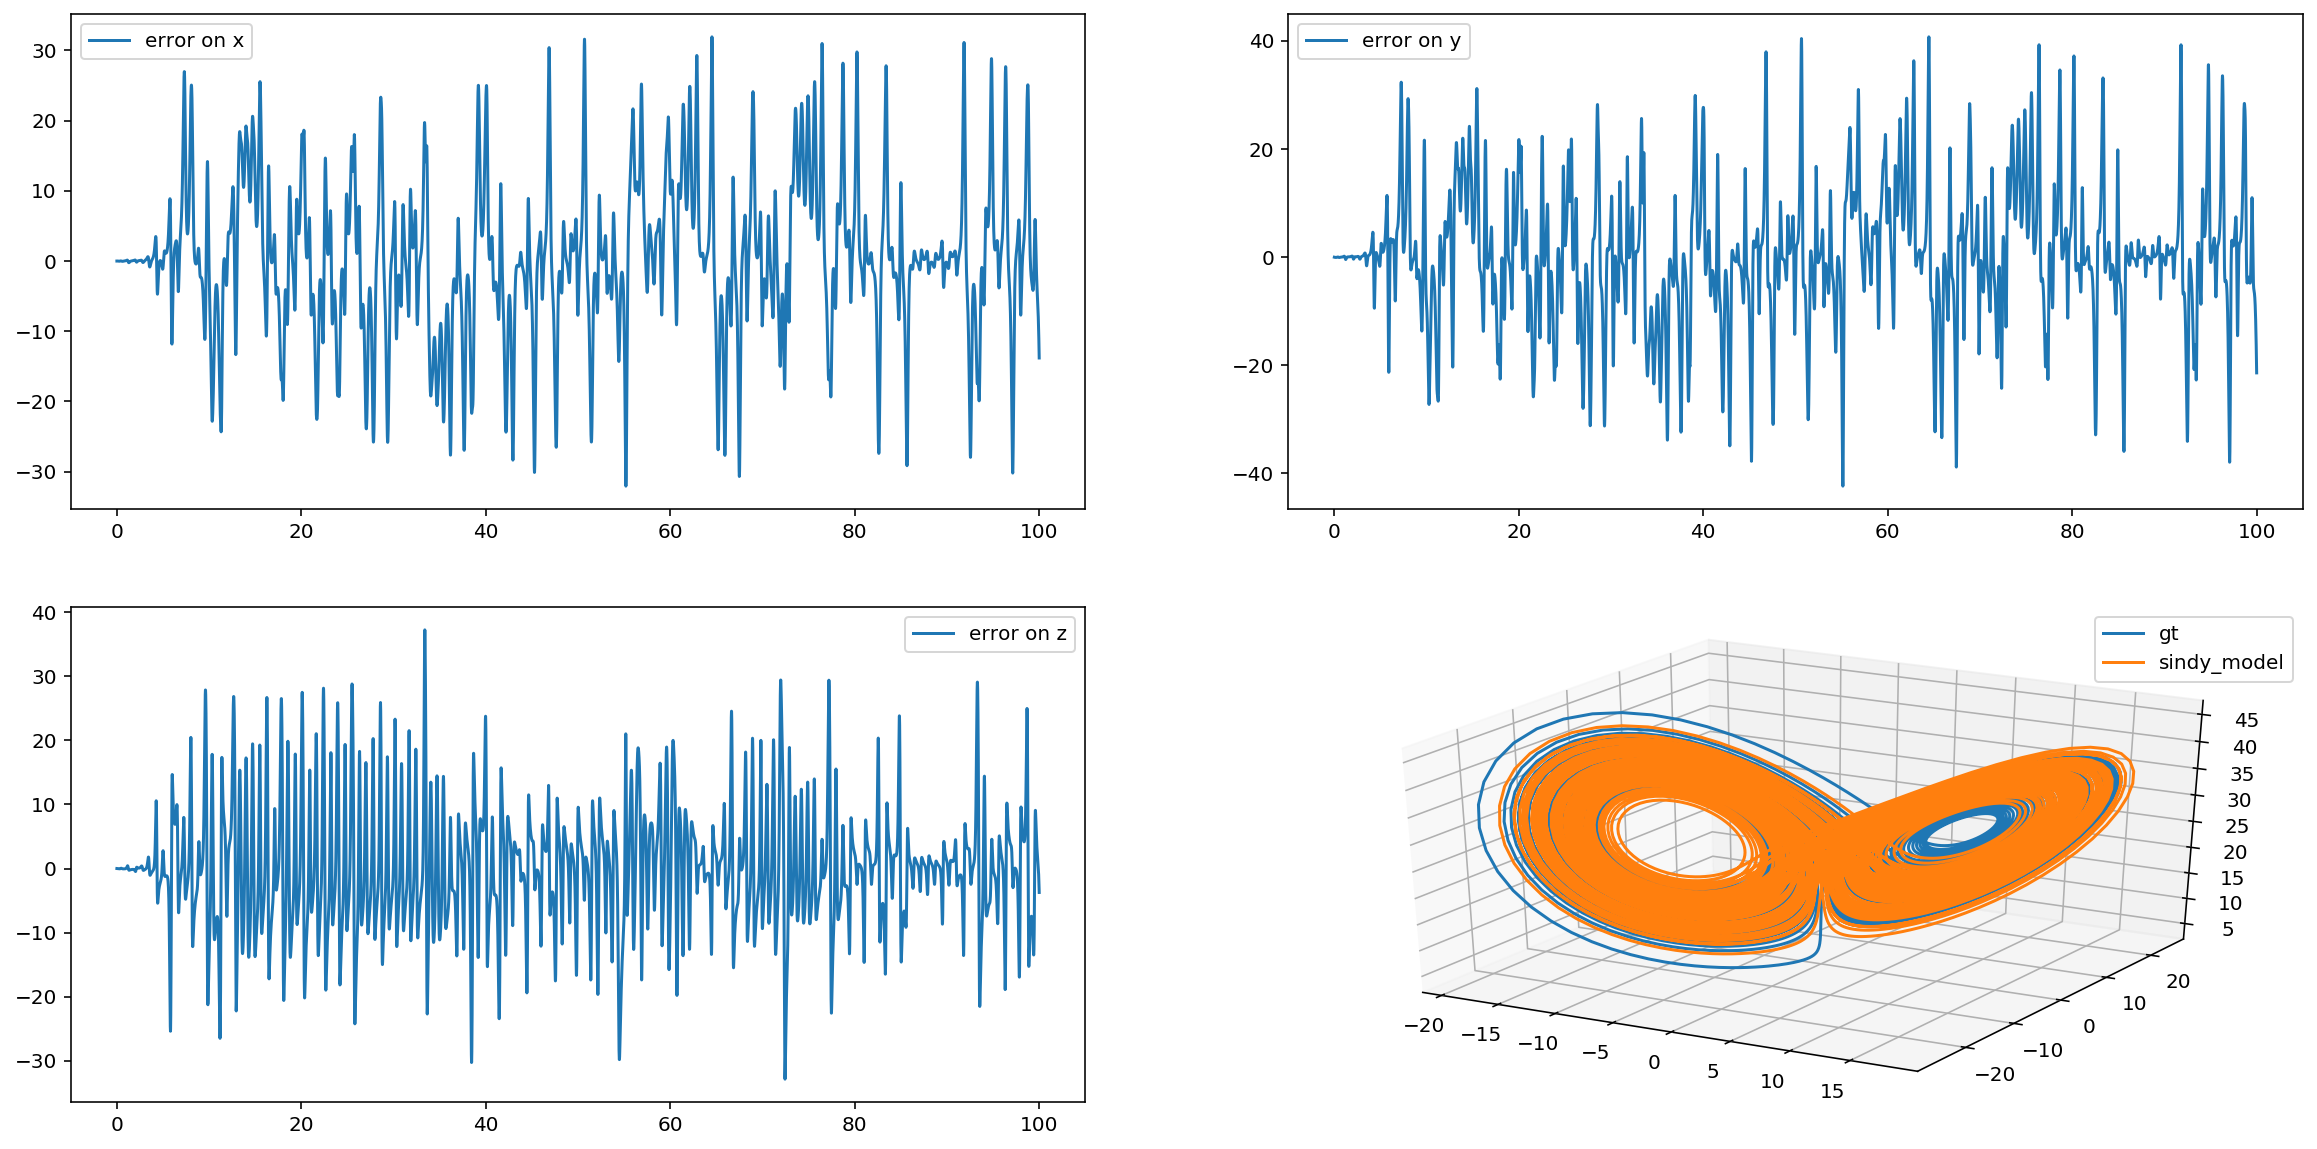

In [28]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(t, x[:,0]-x_hst[:,0], label='error on x')
plt.legend()
plt.subplot(222)
plt.plot(t, x[:,1]-x_hst[:,1], label='error on y')
plt.legend()
plt.subplot(223)
plt.plot(t, x[:,2]-x_hst[:,2], label='error on z')
plt.legend()
plt.subplot(224, projection='3d')
plt.plot(x[:,0], x[:,1], x[:,2], label='gt')
plt.plot(x_hst[:,0], x_hst[:,1], x_hst[:,2], label='sindy_model')
plt.legend()